#Marge datasets and make big training dataset

In [1]:
import numpy as np # linear algebra
import math
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.plotting import scatter_matrix
#import xgboost as xgb
import seaborn as sns

import os
print(os.listdir("../input"))

['sample_submission.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'mulliken_charges.csv', 'train.csv', 'scalar_coupling_contributions.csv', 'test.csv', 'potential_energy.csv', 'structures', 'structures.csv']


In [2]:
#Load data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

#Load sub data
sub = pd.read_csv("../input/sample_submission.csv")
structures = pd.read_csv("../input/structures.csv")
scalar_coupling_contributions = pd.read_csv("../input/scalar_coupling_contributions.csv")
magnetic_shielding_tesors = pd.read_csv("../input/magnetic_shielding_tensors.csv")
dipole_moments = pd.read_csv("../input/dipole_moments.csv")
potential_energy = pd.read_csv("../input/potential_energy.csv")
mulliken_charges = pd.read_csv("../input/mulliken_charges.csv")

In [3]:
print(train.shape)
print(test.shape)
print(sub.shape)
print(structures.shape)
print(scalar_coupling_contributions.shape)
print(magnetic_shielding_tesors.shape)
print(dipole_moments.shape)
print(potential_energy.shape)
print(mulliken_charges.shape)

#check number of unique data 
print(train["molecule_name"].nunique())
print(test["molecule_name"].nunique())
print(structures["atom"].nunique())
print(train["type"].nunique())

(4658147, 6)
(2505542, 5)
(2505542, 2)
(2358657, 6)
(4658147, 8)
(1533537, 11)
(85003, 4)
(85003, 2)
(1533537, 3)
85003
45772
5
8


#Reducee memory usage

Thank to https://www.kaggle.com/todnewman/keras-neural-net-for-champs

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)
structures = reduce_mem_usage(structures)
mulliken_charges = reduce_mem_usage(mulliken_charges)
magnetic_shielding_tesors = reduce_mem_usage(magnetic_shielding_tesors)
print(train.shape, test.shape, structures.shape, mulliken_charges.shape, magnetic_shielding_tesors.shape)

Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
(4658147, 6) (2505542, 5) (2358657, 6) (1533537, 3) (1533537, 11)


#Feature Engineering  
I want to marge dataset and add new features.

In [6]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

Now, marge 2 datasets!

In [7]:
train_structure = map_atom_info(train, 0)
train_structure = map_atom_info(train_structure, 1)

In [8]:
train_structure.head(20)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,C,-0.012695,1.085938,0.008003
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,1.011719,1.463867,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.541016,1.447266,-0.876465
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.523926,1.437500,0.906250
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,C,-0.012695,1.085938,0.008003
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.541016,1.447266,-0.876465
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.523926,1.437500,0.906250
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,C,-0.012695,1.085938,0.008003
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,H,-0.541016,1.447266,-0.876465,H,-0.523926,1.437500,0.906250
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,C,-0.012695,1.085938,0.008003


In [9]:
test_structure = map_atom_info(test, 0)
test_structure = map_atom_info(test_structure, 1)

In [10]:
test_structure.head(20)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662109,0.000000,1.000000,C,0.599609,0.000000,1.000000
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662109,0.000000,1.000000,C,-0.599609,0.000000,1.000000
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662109,0.000000,1.000000,H,1.662109,0.000000,1.000000
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662109,0.000000,1.000000,C,0.599609,0.000000,1.000000
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662109,0.000000,1.000000,C,-0.599609,0.000000,1.000000
5,4658152,dsgdb9nsd_000015,3,0,1JHC,H,1.004883,1.810547,0.004658,C,-0.014824,1.392578,0.005672
6,4658153,dsgdb9nsd_000015,3,2,3JHC,H,1.004883,1.810547,0.004658,C,0.638184,-0.553223,-1.113281
7,4658154,dsgdb9nsd_000015,3,4,2JHH,H,1.004883,1.810547,0.004658,H,-0.546875,1.792969,-0.872559
8,4658155,dsgdb9nsd_000015,3,5,2JHH,H,1.004883,1.810547,0.004658,H,-0.529785,1.722656,0.911133
9,4658156,dsgdb9nsd_000015,4,0,1JHC,H,-0.546875,1.792969,-0.872559,C,-0.014824,1.392578,0.005672


OK, next let's calculate distunce of atoms.  
The distunce of atoms is sqrt((x_0 - x_1)^2 + (y_0 - y_1)^2 + (z_0 - z_1)^2), so I use numpy.linalg.norm.

In [11]:
train_p_0 = train_structure[['x_0', 'y_0', 'z_0']].values
train_p_1 = train_structure[['x_1', 'y_1', 'z_1']].values
train_structure['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
#add the distance from molecule center
train_structure['dist_from_center_0'] = np.linalg.norm(train_p_0, axis=1)
train_structure['dist_from_center_1'] = np.linalg.norm(train_p_1, axis=1)
train_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,C,-0.012695,1.085938,0.008003,1.091797,0.006702,1.085938
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,1.011719,1.463867,0.000277,1.783203,0.006702,1.779297
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.541016,1.447266,-0.876465,1.782227,0.006702,1.776367
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.523926,1.437500,0.906250,1.783203,0.006702,1.777344
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,C,-0.012695,1.085938,0.008003,1.091797,1.779297,1.085938
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.541016,1.447266,-0.876465,1.783203,1.779297,1.776367
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.523926,1.437500,0.906250,1.782227,1.779297,1.777344
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,C,-0.012695,1.085938,0.008003,1.091797,1.776367,1.085938
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,H,-0.541016,1.447266,-0.876465,H,-0.523926,1.437500,0.906250,1.783203,1.776367,1.777344
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,C,-0.012695,1.085938,0.008003,1.091797,1.777344,1.085938


In [12]:
test_p_0 = test_structure[['x_0', 'y_0', 'z_0']].values
test_p_1 = test_structure[['x_1', 'y_1', 'z_1']].values
test_structure['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)
#add the distance from molecule center
test_structure['dist_from_center_0'] = np.linalg.norm(test_p_0, axis=1)
test_structure['dist_from_center_1'] = np.linalg.norm(test_p_1, axis=1)
test_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662109,0.000000,1.000000,C,0.599609,0.000000,1.000000,2.261719,1.939453,1.166016
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662109,0.000000,1.000000,C,-0.599609,0.000000,1.000000,1.062500,1.939453,1.166016
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662109,0.000000,1.000000,H,1.662109,0.000000,1.000000,3.324219,1.939453,1.939453
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662109,0.000000,1.000000,C,0.599609,0.000000,1.000000,1.062500,1.939453,1.166016
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662109,0.000000,1.000000,C,-0.599609,0.000000,1.000000,2.261719,1.939453,1.166016
5,4658152,dsgdb9nsd_000015,3,0,1JHC,H,1.004883,1.810547,0.004658,C,-0.014824,1.392578,0.005672,1.101562,2.070312,1.392578
6,4658153,dsgdb9nsd_000015,3,2,3JHC,H,1.004883,1.810547,0.004658,C,0.638184,-0.553223,-1.113281,2.640625,2.070312,1.397461
7,4658154,dsgdb9nsd_000015,3,4,2JHH,H,1.004883,1.810547,0.004658,H,-0.546875,1.792969,-0.872559,1.782227,2.070312,2.066406
8,4658155,dsgdb9nsd_000015,3,5,2JHH,H,1.004883,1.810547,0.004658,H,-0.529785,1.722656,0.911133,1.785156,2.070312,2.019531
9,4658156,dsgdb9nsd_000015,4,0,1JHC,H,-0.546875,1.792969,-0.872559,C,-0.014824,1.392578,0.005672,1.102539,2.066406,1.392578


Academically, atomic number become large, scalar coupling constant also become large.  
So, I want to add atomic number information in dataset.

In [13]:
train_structure["atomic_number_0"]=train_structure["atom_0"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)
train_structure["atomic_number_1"]=train_structure["atom_1"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)

In [14]:
train_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1,atomic_number_0,atomic_number_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.812500,H,0.002150,-0.006031,0.001976,C,-0.012695,1.085938,0.008003,1.091797,0.006702,1.085938,1,6
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,1.011719,1.463867,0.000277,1.783203,0.006702,1.779297,1,1
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.541016,1.447266,-0.876465,1.782227,0.006702,1.776367,1,1
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.257812,H,0.002150,-0.006031,0.001976,H,-0.523926,1.437500,0.906250,1.783203,0.006702,1.777344,1,1
4,4,dsgdb9nsd_000001,2,0,1JHC,84.812500,H,1.011719,1.463867,0.000277,C,-0.012695,1.085938,0.008003,1.091797,1.779297,1.085938,1,6
5,5,dsgdb9nsd_000001,2,3,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.541016,1.447266,-0.876465,1.783203,1.779297,1.776367,1,1
6,6,dsgdb9nsd_000001,2,4,2JHH,-11.257812,H,1.011719,1.463867,0.000277,H,-0.523926,1.437500,0.906250,1.782227,1.779297,1.777344,1,1
7,7,dsgdb9nsd_000001,3,0,1JHC,84.812500,H,-0.541016,1.447266,-0.876465,C,-0.012695,1.085938,0.008003,1.091797,1.776367,1.085938,1,6
8,8,dsgdb9nsd_000001,3,4,2JHH,-11.257812,H,-0.541016,1.447266,-0.876465,H,-0.523926,1.437500,0.906250,1.783203,1.776367,1.777344,1,1
9,9,dsgdb9nsd_000001,4,0,1JHC,84.812500,H,-0.523926,1.437500,0.906250,C,-0.012695,1.085938,0.008003,1.091797,1.777344,1.085938,1,6


In [15]:
test_structure["atomic_number_0"]=test_structure["atom_0"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)
test_structure["atomic_number_1"]=test_structure["atom_1"].replace("H", 1).replace("C", 6).replace("N", 7).replace("O", 8).replace("F", 9)

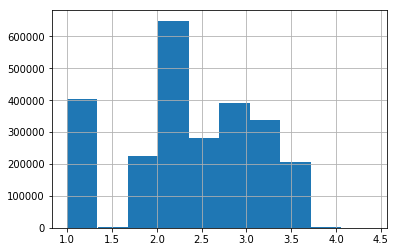

In [16]:
test_structure["dist"].hist()

In addition, maybe coupling number have effect for scalar coupling constant, let's add that.

In [17]:
train_structure["coupling_number_0"]=train_structure["atom_0"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)
train_structure["coupling_number_1"]=train_structure["atom_1"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)

In [18]:
test_structure["coupling_number_0"]=test_structure["atom_0"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)
test_structure["coupling_number_1"]=test_structure["atom_1"].replace("H", 1).replace("C", 4).replace("N", 3).replace("O", 2).replace("F", 1)

In [19]:
test_structure.head(10)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1,atomic_number_0,atomic_number_1,coupling_number_0,coupling_number_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662109,0.000000,1.000000,C,0.599609,0.000000,1.000000,2.261719,1.939453,1.166016,1,6,1,4
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662109,0.000000,1.000000,C,-0.599609,0.000000,1.000000,1.062500,1.939453,1.166016,1,6,1,4
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662109,0.000000,1.000000,H,1.662109,0.000000,1.000000,3.324219,1.939453,1.939453,1,1,1,1
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662109,0.000000,1.000000,C,0.599609,0.000000,1.000000,1.062500,1.939453,1.166016,1,6,1,4
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662109,0.000000,1.000000,C,-0.599609,0.000000,1.000000,2.261719,1.939453,1.166016,1,6,1,4
5,4658152,dsgdb9nsd_000015,3,0,1JHC,H,1.004883,1.810547,0.004658,C,-0.014824,1.392578,0.005672,1.101562,2.070312,1.392578,1,6,1,4
6,4658153,dsgdb9nsd_000015,3,2,3JHC,H,1.004883,1.810547,0.004658,C,0.638184,-0.553223,-1.113281,2.640625,2.070312,1.397461,1,6,1,4
7,4658154,dsgdb9nsd_000015,3,4,2JHH,H,1.004883,1.810547,0.004658,H,-0.546875,1.792969,-0.872559,1.782227,2.070312,2.066406,1,1,1,1
8,4658155,dsgdb9nsd_000015,3,5,2JHH,H,1.004883,1.810547,0.004658,H,-0.529785,1.722656,0.911133,1.785156,2.070312,2.019531,1,1,1,1
9,4658156,dsgdb9nsd_000015,4,0,1JHC,H,-0.546875,1.792969,-0.872559,C,-0.014824,1.392578,0.005672,1.102539,2.066406,1.392578,1,6,1,4


Next, I want to add number of atoms in molecule....., but my code didn't work well no matter how many challanges I tried.
Please give me a good idea!

In [20]:
#train_structure.groupby("molecule_name")

After from here, add features which were provided by following kernels:  
https://www.kaggle.com/todnewman/keras-neural-net-for-champs  
https://www.kaggle.com/adrianoavelar/bond-calculation-lb-0-82?scriptVersionId=15911797  


In [21]:
#add atomic radius and electronegativity
train_structure["atomic_radius_0"]=train_structure["atom_0"].replace("H", 0.37).replace("C", 0.77).replace("N", 0.75).replace("O", 0.73).replace("F", 0.71)
train_structure["atomic_radius_1"]=train_structure["atom_1"].replace("H", 0.37).replace("C", 0.77).replace("N", 0.75).replace("O", 0.73).replace("F", 0.71)
test_structure["atomic_radius_0"]=test_structure["atom_0"].replace("H", 0.37).replace("C", 0.77).replace("N", 0.75).replace("O", 0.73).replace("F", 0.71)
test_structure["atomic_radius_1"]=test_structure["atom_1"].replace("H", 0.37).replace("C", 0.77).replace("N", 0.75).replace("O", 0.73).replace("F", 0.71)

train_structure["electronegativity_0"]=train_structure["atom_0"].replace("H", 2.2).replace("C", 2.55).replace("N", 3.04).replace("O", 3.44).replace("F", 3.98)
train_structure["electronegativity_1"]=train_structure["atom_1"].replace("H", 2.2).replace("C", 2.55).replace("N", 3.04).replace("O", 3.44).replace("F", 3.98)
test_structure["electronegativity_0"]=test_structure["atom_0"].replace("H", 2.2).replace("C", 2.55).replace("N", 3.04).replace("O", 3.44).replace("F", 3.98)
test_structure["electronegativity_1"]=test_structure["atom_1"].replace("H", 2.2).replace("C", 2.55).replace("N", 3.04).replace("O", 3.44).replace("F", 3.98)

test_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1,atomic_number_0,atomic_number_1,coupling_number_0,coupling_number_1,atomic_radius_0,atomic_radius_1,electronegativity_0,electronegativity_1
0,4658147,dsgdb9nsd_000004,2,0,2JHC,H,-1.662109,0.0,1.0,C,0.599609,0.0,1.0,2.261719,1.939453,1.166016,1,6,1,4,0.37,0.77,2.2,2.55
1,4658148,dsgdb9nsd_000004,2,1,1JHC,H,-1.662109,0.0,1.0,C,-0.599609,0.0,1.0,1.062500,1.939453,1.166016,1,6,1,4,0.37,0.77,2.2,2.55
2,4658149,dsgdb9nsd_000004,2,3,3JHH,H,-1.662109,0.0,1.0,H,1.662109,0.0,1.0,3.324219,1.939453,1.939453,1,1,1,1,0.37,0.37,2.2,2.20
3,4658150,dsgdb9nsd_000004,3,0,1JHC,H,1.662109,0.0,1.0,C,0.599609,0.0,1.0,1.062500,1.939453,1.166016,1,6,1,4,0.37,0.77,2.2,2.55
4,4658151,dsgdb9nsd_000004,3,1,2JHC,H,1.662109,0.0,1.0,C,-0.599609,0.0,1.0,2.261719,1.939453,1.166016,1,6,1,4,0.37,0.77,2.2,2.55


In [22]:
train_structure = reduce_mem_usage(train_structure)
test_structure = reduce_mem_usage(test_structure)

Mem. usage decreased to 346.50 Mb (40.0% reduction)
Mem. usage decreased to 181.60 Mb (40.6% reduction)


#Build LightGBM model

reference kernels:  
https://www.kaggle.com/super13579/simple-eda-and-lightgbm  
https://www.kaggle.com/abhishek/competition-metric  


In [23]:
import lightgbm as lgb
from sklearn.model_selection import GroupKFold,StratifiedKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import time

In [24]:
#Prepare dataset
# Label Encoding
for f in ['type', 'atom_0', 'atom_1']:
    lbl = LabelEncoder()
    lbl.fit(list(train_structure[f].values) + list(test_structure[f].values))
    train_structure[f] = lbl.transform(list(train_structure[f].values))
    test_structure[f] = lbl.transform(list(test_structure[f].values))
train_structure.head(5)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1,atomic_number_0,atomic_number_1,coupling_number_0,coupling_number_1,atomic_radius_0,atomic_radius_1,electronegativity_0,electronegativity_1
0,0,dsgdb9nsd_000001,1,0,0,84.812500,0,0.002150,-0.006031,0.001976,0,-0.012695,1.085938,0.008003,1.091797,0.006702,1.085938,1,6,1,4,0.370117,0.770020,2.199219,2.550781
1,1,dsgdb9nsd_000001,1,2,3,-11.257812,0,0.002150,-0.006031,0.001976,1,1.011719,1.463867,0.000277,1.783203,0.006702,1.779297,1,1,1,1,0.370117,0.370117,2.199219,2.199219
2,2,dsgdb9nsd_000001,1,3,3,-11.257812,0,0.002150,-0.006031,0.001976,1,-0.541016,1.447266,-0.876465,1.782227,0.006702,1.776367,1,1,1,1,0.370117,0.370117,2.199219,2.199219
3,3,dsgdb9nsd_000001,1,4,3,-11.257812,0,0.002150,-0.006031,0.001976,1,-0.523926,1.437500,0.906250,1.783203,0.006702,1.777344,1,1,1,1,0.370117,0.370117,2.199219,2.199219
4,4,dsgdb9nsd_000001,2,0,0,84.812500,0,1.011719,1.463867,0.000277,0,-0.012695,1.085938,0.008003,1.091797,1.779297,1.085938,1,6,1,4,0.370117,0.770020,2.199219,2.550781


In [25]:
def del_cols(df, cols):
    del_cols_list_ = [l for l in cols if l in df]
    df = df.drop(del_cols_list_,axis=1)
    return df

y_train = train_structure.scalar_coupling_constant
x_train = del_cols(train_structure, ["molecule_name", "scalar_coupling_constant", "id"])
x_test = del_cols(test_structure, ["molecule_name", "id"])
x_train.head(5)

,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,dist,dist_from_center_0,dist_from_center_1,atomic_number_0,atomic_number_1,coupling_number_0,coupling_number_1,atomic_radius_0,atomic_radius_1,electronegativity_0,electronegativity_1
0,1,0,0,0,0.002150,-0.006031,0.001976,0,-0.012695,1.085938,0.008003,1.091797,0.006702,1.085938,1,6,1,4,0.370117,0.770020,2.199219,2.550781
1,1,2,3,0,0.002150,-0.006031,0.001976,1,1.011719,1.463867,0.000277,1.783203,0.006702,1.779297,1,1,1,1,0.370117,0.370117,2.199219,2.199219
2,1,3,3,0,0.002150,-0.006031,0.001976,1,-0.541016,1.447266,-0.876465,1.782227,0.006702,1.776367,1,1,1,1,0.370117,0.370117,2.199219,2.199219
3,1,4,3,0,0.002150,-0.006031,0.001976,1,-0.523926,1.437500,0.906250,1.783203,0.006702,1.777344,1,1,1,1,0.370117,0.370117,2.199219,2.199219
4,2,0,0,0,1.011719,1.463867,0.000277,0,-0.012695,1.085938,0.008003,1.091797,1.779297,1.085938,1,6,1,4,0.370117,0.770020,2.199219,2.550781


In [26]:
n_fold = 3
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Following code fetch from reference, it looks toolbox of many kind of models.  
Very easy to use!  

In [27]:
def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [28]:
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

Fold 1 started at Sat Jul  6 08:29:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.1494	valid_1's l1: 2.16667
[1000]	training's l1: 2.05637	valid_1's l1: 2.08948
[1500]	training's l1: 1.99755	valid_1's l1: 2.04499
[2000]	training's l1: 1.95129	valid_1's l1: 2.01211
[2500]	training's l1: 1.91369	valid_1's l1: 1.98696
[3000]	training's l1: 1.88248	valid_1's l1: 1.96793
[3500]	training's l1: 1.85441	valid_1's l1: 1.95157
[4000]	training's l1: 1.82958	valid_1's l1: 1.93788
[4500]	training's l1: 1.80749	valid_1's l1: 1.92661
[5000]	training's l1: 1.78557	valid_1's l1: 1.91519
[5500]	training's l1: 1.7661	valid_1's l1: 1.90571
[6000]	training's l1: 1.74783	valid_1's l1: 1.89711
[6500]	training's l1: 1.72965	valid_1's l1: 1.88834
[7000]	training's l1: 1.713	valid_1's l1: 1.88086
[7500]	training's l1: 1.69705	valid_1's l1: 1.87381
[8000]	training's l1: 1.68214	valid_1's l1: 1.86759
[8500]	training's l1: 1.66763	valid_1's l1: 1.86173
[9000]	training

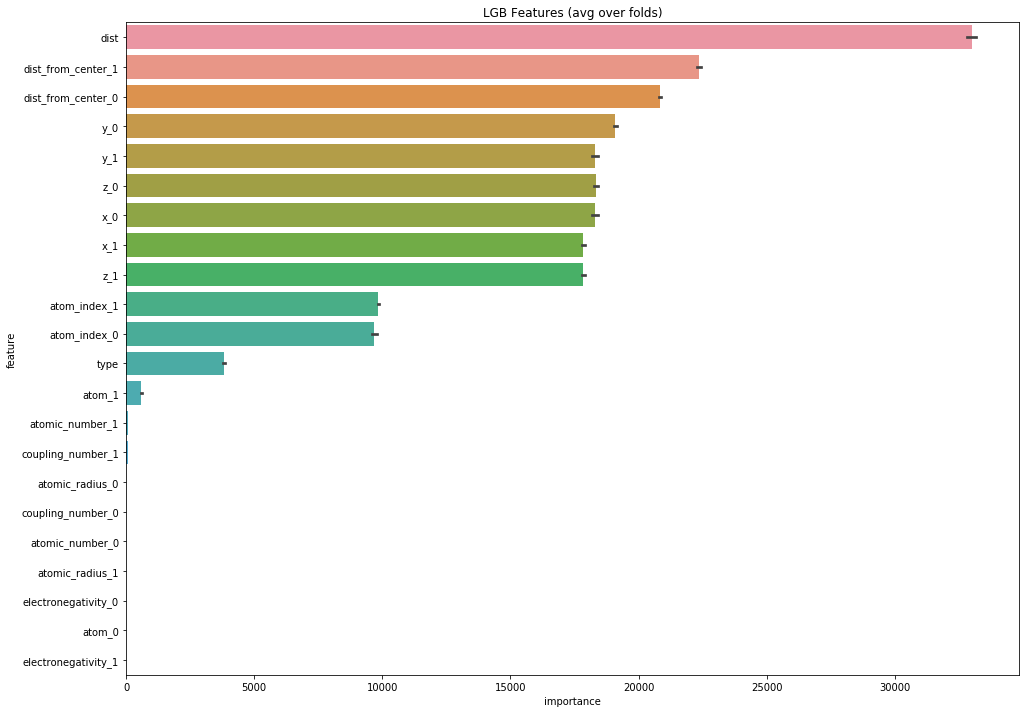

In [29]:
#Set hyper parameters
params = {'num_leaves': 64,
          'min_child_samples': 64,
          'objective': 'regression',
          'max_depth': 8,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }
result_dict_lgb_oof = train_model_regression(X=x_train, 
                                             X_test=x_test, 
                                             y=y_train, 
                                             params=params, 
                                             folds=folds,
                                             model_type='lgb',
                                             eval_metric='group_mae',
                                             plot_feature_importance=True,
                                             verbose=500, 
                                             early_stopping_rounds=200, 
                                             n_estimators=10000)

#Submission

In [30]:
sample_submission = pd.read_csv('../input/sample_submission.csv')

benchmark = sample_submission.copy()
benchmark['scalar_coupling_constant'] = result_dict_lgb_oof['prediction']
benchmark.to_csv('LGBM_submission.csv',index=False)

In [31]:
benchmark.head()

,id,scalar_coupling_constant
0,4658147,5.087405
1,4658148,187.542154
2,4658149,6.133801
3,4658150,197.106233
4,4658151,5.950188


(array([1.459000e+03, 1.184810e+05, 7.939900e+04, 5.349840e+05,
        1.184592e+06, 1.688980e+05, 1.025200e+04, 1.455000e+03,
        8.140000e+02, 4.259000e+03, 4.532000e+03, 4.012000e+03,
        2.300000e+03, 5.669000e+03, 3.221000e+03, 5.890000e+02,
        6.400000e+01, 1.353700e+04, 1.748920e+05, 7.972600e+04,
        1.778700e+04, 1.361600e+04, 2.709500e+04, 2.106500e+04,
        1.109800e+04, 7.167000e+03, 6.307000e+03, 2.803000e+03,
        4.410000e+02, 1.220000e+02, 3.300000e+01, 8.000000e+00,
        2.000000e+01, 2.400000e+01, 5.400000e+01, 6.700000e+01,
        4.710000e+02, 3.718000e+03, 5.050000e+02, 6.000000e+00]),
 array([-22.5641555 , -16.74641459, -10.92867368,  -5.11093278,
          0.70680813,   6.52454904,  12.34228994,  18.16003085,
         23.97777176,  29.79551266,  35.61325357,  41.43099448,
         47.24873538,  53.06647629,  58.8842172 ,  64.7019581 ,
         70.51969901,  76.33743992,  82.15518083,  87.97292173,
         93.79066264,  99.60840355, 10

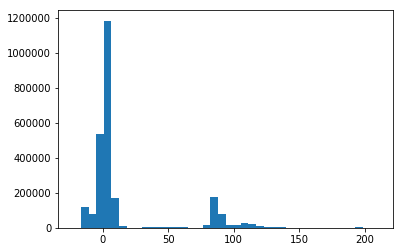

In [33]:
#check result
plt.hist(result_dict_lgb_oof['prediction'], bins=40)

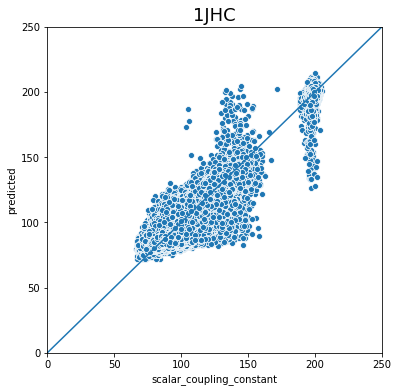

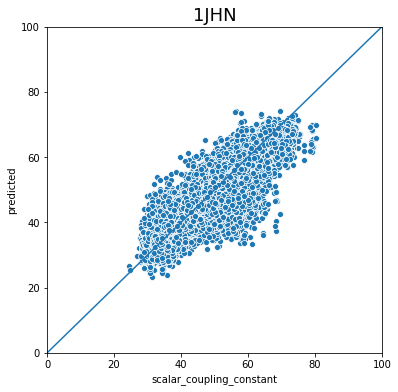

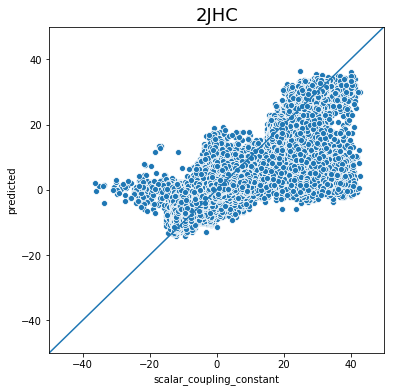

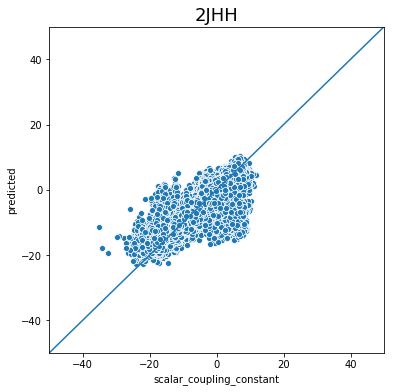

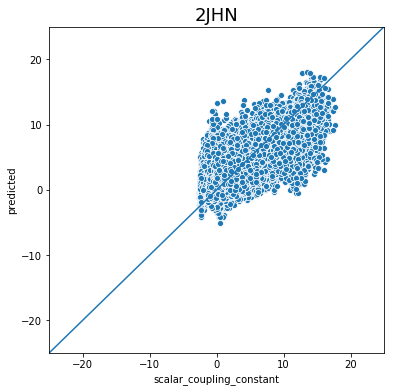

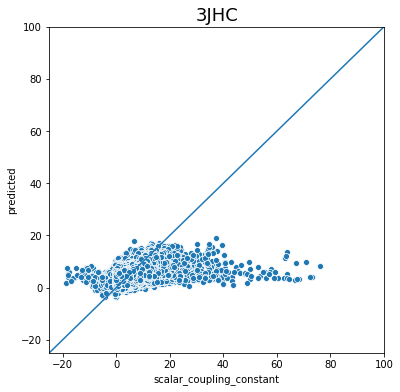

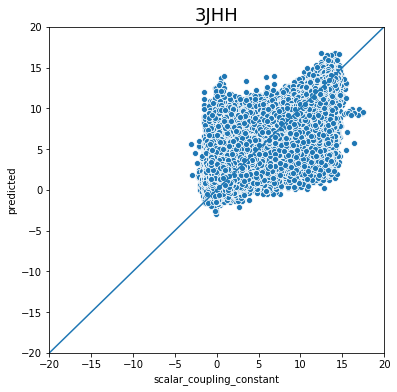

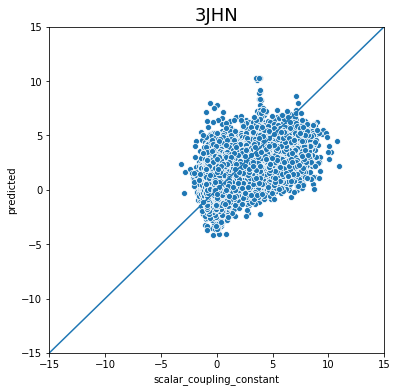

In [40]:
plot_data = pd.DataFrame(train_structure['scalar_coupling_constant'])
plot_data.index.name = 'id'
plot_data['yhat'] = result_dict_lgb_oof['oof']
plot_data['type'] = train['type']

def plot_oof_preds(ctype, llim, ulim):
        plt.figure(figsize=(6,6))
        sns.scatterplot(x='scalar_coupling_constant',y='yhat',
                        data=plot_data.loc[plot_data['type']==ctype,
                        ['scalar_coupling_constant', 'yhat']]);
        plt.xlim((llim, ulim))
        plt.ylim((llim, ulim))
        plt.plot([llim, ulim], [llim, ulim])
        plt.xlabel('scalar_coupling_constant')
        plt.ylabel('predicted')
        plt.title(f'{ctype}', fontsize=18)
        plt.show()

plot_oof_preds('1JHC', 0, 250)
plot_oof_preds('1JHN', 0, 100)
plot_oof_preds('2JHC', -50, 50)
plot_oof_preds('2JHH', -50, 50)
plot_oof_preds('2JHN', -25, 25)
plot_oof_preds('3JHC', -25, 100)
plot_oof_preds('3JHH', -20, 20)
plot_oof_preds('3JHN', -15, 15)